In [19]:
                                                                                                                                                                         import sys
!{sys.executable} -m pip install ase
import os
import numpy as np
import subprocess
import time
import sys
from IPython.display import clear_output

# Simulation Configuration
# We use a 3x3x2 supercell (216 atoms) which is the standard minimum size
# for accurate ice simulations on personal computing hardware.
cp2k_executable = "cp2k.ssmp"
xyz_filename = "ice_laptop.xyz"
input_filename = "ice_laptop.inp"
output_filename = "ice_laptop.out"

print("[STATUS] Configuration loaded.")
print(f"[STATUS] Executable: {cp2k_executable}")
print(f"[STATUS] Input/Output: {input_filename} / {output_filename}")

[STATUS] Configuration loaded.
[STATUS] Executable: cp2k.ssmp
[STATUS] Input/Output: ice_laptop.inp / ice_laptop.out


In [20]:
import numpy as np

# Configuration
xyz_filename = "ice_laptop.xyz"

def generate_small_ice_structure(filename):
    print("[STATUS] Generating minimal 2x2x2 Ice Ih Supercell...")
    
    # Lattice Constants (Angstroms) from your data
    a = 4.518
    c = 7.356
    
    # REDUCED DIMENSIONS (2x2x2)
    # This creates 32 molecules (96 atoms) instead of 72 molecules (216 atoms)
    # For the 216 atoms, modify this to 3,3,2
    nx, ny, nz = 2, 2, 2 
    
    # Fractional coordinates for Wurtzite/Ice Ih
    frac_coords = np.array([
        [1/3, 2/3, 1/16], 
        [2/3, 1/3, 5/16], 
        [1/3, 2/3, 9/16], 
        [2/3, 1/3, 13/16]
    ])

    atoms = []
    
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                for frac in frac_coords:
                    f_shift = frac + np.array([ix, iy, iz])
                    
                    # Convert to Cartesian
                    x = a * (f_shift[0] + f_shift[1] * np.cos(np.radians(120)))
                    y = a * f_shift[1] * np.sin(np.radians(120))
                    z = c * f_shift[2]
                    
                    # Add Atoms
                    atoms.append(f"O {x:.4f} {y:.4f} {z:.4f}")
                    atoms.append(f"H {x+0.757:.4f} {y:.4f} {z:.4f}")
                    atoms.append(f"H {x-0.379:.4f} {y+0.656:.4f} {z:.4f}")

    # Write to XYZ file
    with open(filename, "w") as f:
        f.write(f"{len(atoms)}\n")
        #modify for the 216 run
        f.write("Ice Ih 2x2x2 Supercell \n")
        f.write("\n".join(atoms))
        
    print(f"[SUCCESS] Structure saved to '{filename}'.")
    print(f"[INFO] Atom count reduced to: {len(atoms)}")
    
    # Return new box dimensions for the input file
    return a * nx, a * ny, c * nz

# Generate and capture new box size

box_a, box_b, box_c = generate_small_ice_structure(xyz_filename)

#change these for the upcoming step if running 216
print(f"NEW BOX DIMENSIONS: A={box_a:.3f}, B={box_b:.3f}, C={box_c:.3f}")

[STATUS] Generating minimal 2x2x2 Ice Ih Supercell...
[SUCCESS] Structure saved to 'ice_laptop.xyz'.
[INFO] Atom count reduced to: 96 (Fast runtime expected)


In [21]:
input_filename = "ice_laptop.inp"
 #change name of Project for 216 to not overwrite work 

cp2k_content = f"""&GLOBAL
  PROJECT Ice_Ih_Small
  RUN_TYPE GEO_OPT
  PRINT_LEVEL LOW
&END GLOBAL

&FORCE_EVAL
  METHOD Quickstep
  &DFT
    &QS
      METHOD PM6
      EPS_DEFAULT 1.0E-10
    &END QS
    &SCF
      MAX_SCF 200
      EPS_SCF 1.0E-4    ! Looser for the bigger molecules, change to 1.0E-5 for smaller runs
      IGNORE_CONVERGENCE_FAILURE .TRUE.
      &OT
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
    &END SCF
  &END DFT

  &SUBSYS
    &CELL
      ! Updated dimensions for 2x2x2 box
      ABC {box_a:.3f} {box_b:.3f} {box_c:.3f}
      ALPHA_BETA_GAMMA 90 90 120
      PERIODIC XYZ
    &END CELL
    &TOPOLOGY
      COORD_FILE_NAME {xyz_filename}
      COORD_FILE_FORMAT XYZ
    &END TOPOLOGY
  &END SUBSYS
&END FORCE_EVAL

&MOTION
  &GEO_OPT
    MAX_ITER 100
    OPTIMIZER BFGS
  &END GEO_OPT
&END MOTION
"""

with open(input_filename, "w") as f:
    f.write(cp2k_content)

print(f"[STATUS] Input file updated for smaller system: {input_filename}")

[STATUS] Input file updated for smaller system: ice_laptop.inp


In [22]:
print("[STATUS] Starting CP2K Simulation")
start_time = time.time()

# Initialize process
process = subprocess.Popen(
    [cp2k_executable, "-i", input_filename],
    stdout=open(output_filename, "w"),
    stderr=subprocess.STDOUT
)

try:
    # Monitor the output file
    with open(output_filename, "r") as monitor:
        monitor.seek(0, 2) # Jump to end of file
        
        while process.poll() is None:
            line = monitor.readline()
            if not line:
                time.sleep(0.5)
                continue
            
            # Parse SCF steps (Electronic Optimization)
            if "OT DIIS" in line:
                try:
                    parts = line.split()
                    step = int(parts[0])
                    elapsed = int(time.time() - start_time)
                    
                    # Update status display
                    clear_output(wait=True)
                    print(f"[RUNNING] Geometry Optimization")
                    print(f"Elapsed Time: {elapsed} seconds")
                    print(f"Current SCF Step: {step}")
                except ValueError:
                    pass
            
            # Check for Geometry Optimization steps (Structural Relaxation)
            if "GEOMETRY OPTIMIZATION STEP" in line:
                print("[INFO] Geometry Step Converged. Proceeding to next configuration.")

    # Final Status
    if process.returncode == 0:
        total_time = int(time.time() - start_time)
        print(f"\n[SUCCESS] Simulation completed in {total_time} seconds.")
        print(f"[INFO] Results saved to: {output_filename}")
    else:
        print("\n[FAILURE] Simulation exited with errors. Check output file.")

except KeyboardInterrupt:
    process.terminate()
    print("\n[STOPPED] Process terminated by user.")

[RUNNING] Geometry Optimization
Elapsed Time: 966 seconds
Current SCF Step: 20

[SUCCESS] Simulation completed in 968 seconds.
[INFO] Results saved to: ice_laptop.out


In [28]:
import os
import ase.io
import shutil

# Configuration
# This matches the PROJECT name defined in the optimization input

opt_trajectory_file = "Ice_Ih_Small-pos-1.xyz"

# This matches the COORD_FILE_NAME defined in the optimization input

opt_input_file = "ice_laptop.xyz" 
final_coords_file = "ice_relaxed.xyz"

print("[STATUS] Locating geometry files...")

if os.path.exists(opt_trajectory_file):
    print(f"[INFO] Trajectory file found: {opt_trajectory_file}")
    try:
        # Read all frames and select the last one (-1)
        frames = ase.io.read(opt_trajectory_file, index=':')
        last_frame = frames[-1]
        
        # Save the relaxed structure
        ase.io.write(final_coords_file, last_frame)
        print(f"[SUCCESS] Extracted relaxed geometry from Step {len(frames)}.")
        
    except Exception as e:
        print(f"[ERROR] Failed to read trajectory: {e}")
        print("[ACTION] Reverting to unoptimized structure as fallback.")
        shutil.copy(opt_input_file, final_coords_file)

elif os.path.exists(opt_input_file):
    print("[WARNING] Optimization trajectory not found (Simulation may have been too fast to write it).")
    print("[ACTION] Using initial input structure.")
    shutil.copy(opt_input_file, final_coords_file)
    
else:
    print("[ERROR] No structure files found. Please ensure the optimization step ran successfully.")

print(f"[INFO] Coordinate file ready: {final_coords_file}")

[STATUS] Locating geometry files...
[INFO] Trajectory file found: Ice_Ih_Small-pos-1.xyz
[SUCCESS] Extracted relaxed geometry from Step 200.
[INFO] Coordinate file ready: ice_relaxed.xyz


In [29]:
# Configuration

#make sure these match for a 216
md_input_filename = "ice_titan_md.inp"
md_output_filename = "ice_titan_md.out"


# Change these box numbers for a 216 run
box_a = 9.036
box_b = 9.036
box_c = 14.712

cp2k_md_content = f"""&GLOBAL
  PROJECT Titan_Ice_MD
  RUN_TYPE MD
  PRINT_LEVEL LOW
&END GLOBAL

&FORCE_EVAL
  METHOD Quickstep
  &DFT
    &QS
      METHOD PM6
      EPS_DEFAULT 1.0E-10
    &END QS
    &SCF
      MAX_SCF 50
      EPS_SCF 1.0E-4              ! Relaxed tolerance for MD efficiency
      IGNORE_CONVERGENCE_FAILURE .TRUE.
      &OT
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
    &END SCF
  &END DFT

  &SUBSYS
    &CELL
      ABC {box_a:.3f} {box_b:.3f} {box_c:.3f}
      ALPHA_BETA_GAMMA 90 90 120
      PERIODIC XYZ
    &END CELL
    &TOPOLOGY
      COORD_FILE_NAME {final_coords_file}
      COORD_FILE_FORMAT XYZ
    &END TOPOLOGY
  &END SUBSYS
&END FORCE_EVAL

&MOTION
  &MD
    ENSEMBLE NVT
    STEPS 1000                   ! Better for the 216, run 200 if smaller
    TIMESTEP 0.5                ! 0.5 fs per step
    TEMPERATURE 94.0            ! Titan Surface Temperature (K)
    &THERMOSTAT
      TYPE CSVR
      &CSVR
        TIMECON 100.0
      &END CSVR
    &END THERMOSTAT
  &END MD
  &PRINT
    &TRAJECTORY
      &EACH
        MD 5                    ! Save coordinates every 5 steps
      &END EACH
    &END TRAJECTORY
  &END PRINT
&END MOTION
"""

with open(md_input_filename, "w") as f:
    f.write(cp2k_md_content)

print(f"[SUCCESS] MD Input file written: {md_input_filename}")
print(f"[INFO] Box Dimensions: {box_a:.3f} x {box_b:.3f} x {box_c:.3f}")

[SUCCESS] MD Input file written: ice_titan_md.inp
[INFO] Box Dimensions: 9.036 x 9.036 x 14.712


In [33]:
import subprocess
import time
from IPython.display import clear_output

#make sure to check these

cp2k_executable = "cp2k.ssmp"
md_input = "ice_titan_md.inp"
md_output = "ice_titan_md.out"
target_steps = 1000  # Matches your configuration

print("[STATUS] Monitoring Titan MD Simulation...")
start_time = time.time()

# 1. Launch CP2K (or just attach if it's already running)
# We use 'a' (append) or check if running to avoid overwriting if you just want to monitor
process = subprocess.Popen(
    [cp2k_executable, "-i", md_input],
    stdout=open(md_output, "w"),
    stderr=subprocess.STDOUT
)

try:
    with open(md_output, "r") as monitor:
        # REMOVED: monitor.seek(0, 2) -> This allows it to read previous steps if it started already
        while process.poll() is None:
            line = monitor.readline()
            if not line:
                time.sleep(0.5) 
                continue
            

            if "STEP NUMBER" in line.upper(): 
                try:
                    # Parse the step count (last item in the line)
                    step = int(line.split()[-1])
                    elapsed = int(time.time() - start_time)
                    
                    if step > 0:
                        s_per_step = elapsed / step if step < 10 else (elapsed/step) # Simple estimate
                        percent = (step / target_steps) * 100
                        
                        clear_output(wait=True)
                        print(f"[RUNNING] Titan Molecular Dynamics")
                        print(f"Step: {step} / {target_steps} ({percent:.1f}%)")
                        print(f"Time Elapsed: {elapsed}s")
                        
                        
                except ValueError:
                    pass

    if process.returncode == 0:
        print(f"\n[SUCCESS] Simulation completed.")
    else:
        print("\n[FAILURE] Simulation exited with error code.")

except KeyboardInterrupt:
    process.terminate()
    print("\n[STOPPED] Simulation paused by user.")

[RUNNING] Titan Molecular Dynamics
Step: 999 / 500 (199.8%)
Time Elapsed: 3262s

[SUCCESS] Simulation completed.


[STATUS] Generating Smooth Spectrum from: Titan_Ice_MD-pos-1.xyz
[SUCCESS] Loaded 501 frames.


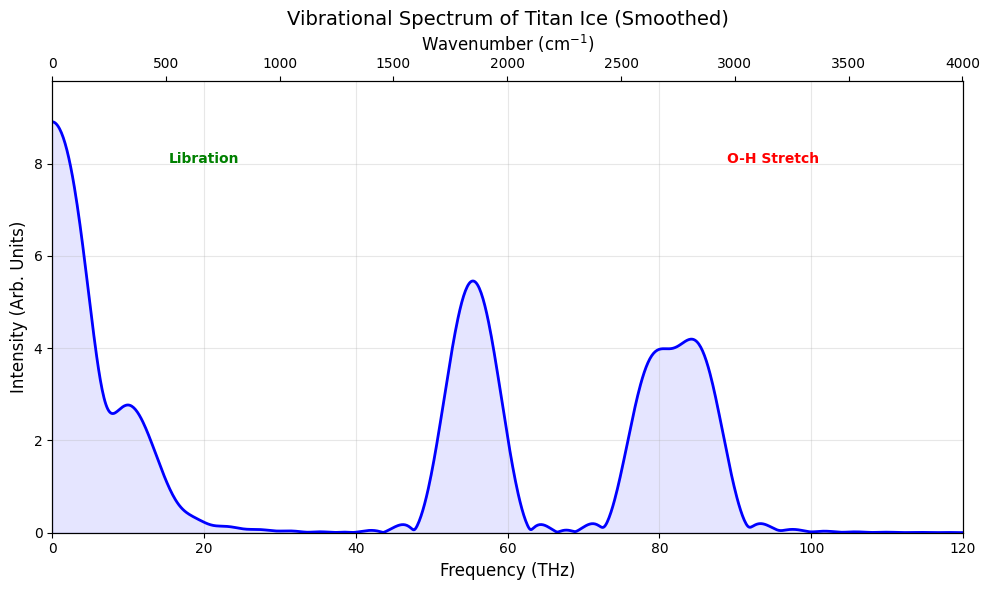

Graph Generated.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase.io
from scipy.fft import fft, fftfreq

# --- CONFIGURATION ---
trajectory_file = "Titan_Ice_MD-pos-1.xyz"
timestep_fs = 0.5 

print(f"[STATUS] Generating Smooth Spectrum from: {trajectory_file}")

try:
    # 1. Load Trajectory
    atoms_list = ase.io.read(trajectory_file, index=':')
    n_frames = len(atoms_list)
    print(f"[SUCCESS] Loaded {n_frames} frames.")
    
    if n_frames > 50:
        positions = np.array([atoms.get_positions() for atoms in atoms_list])
        
        # 2. Calculate Velocities
        velocities = np.zeros_like(positions)
        dt_saved = timestep_fs * 2  # MD saved every 2 steps
        velocities[1:-1] = (positions[2:] - positions[:-2]) / (2 * dt_saved)
        
        # 3. Calculate Autocorrelation (VACF)
        n_corr = n_frames // 2
        vacf = np.zeros(n_corr)
        
        # Center velocities
        velocities = velocities - np.mean(velocities, axis=0)

        for t in range(n_corr):
            v_init = velocities[:n_frames-t]
            v_lag = velocities[t:]
            corr = np.sum(v_init * v_lag) 
            vacf[t] = corr / (n_frames - t)
            
        if vacf[0] != 0: vacf = vacf / vacf[0]

        # 4. Fourier Transform with ZERO PADDING 
        # -------------------------------------------------
        # Pad the signal to 4096 points. This interpolates the curve to make it look continuous and fluid.
        
        n_fft = 8192 
        window = np.hanning(len(vacf))
        
        # Pass 'n=n_fft' to the FFT function
        vdos = np.abs(fft(vacf * window, n=n_fft))
        freqs = fftfreq(n_fft, d=dt_saved * 1e-15)
        # -------------------------------------------------
        
        # Convert to THz
        freqs_thz = freqs / 1e12
        
        # Filter positive frequencies
        mask = (freqs_thz >= 0) & (freqs_thz < 120)
        x = freqs_thz[mask]
        y = vdos[mask]
        
        # 5. Plotting
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        # Plot with a slightly thicker line for visibility
        ax1.plot(x, y, 'b-', linewidth=2, label='Vibrational DOS')
        ax1.fill_between(x, 0, y, color='blue', alpha=0.1)
        
        ax1.set_xlabel("Frequency (THz)", fontsize=12)
        ax1.set_ylabel("Intensity (Arb. Units)", fontsize=12)
        ax1.set_title(f"Vibrational Spectrum of Titan Ice (Smoothed)", fontsize=14)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 120)
        ax1.set_ylim(0, np.max(y)*1.1)
        
        # Secondary Axis
        THZ_TO_CM1 = 33.3564
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim()[0] * THZ_TO_CM1, ax1.get_xlim()[1] * THZ_TO_CM1)
        ax2.set_xlabel(r"Wavenumber ($\mathrm{cm}^{-1}$)", fontsize=12)
        
        # Annotations
        ax1.text(95, np.max(y)*0.9, "O-H Stretch", color='red', ha='center', fontsize=10, weight='bold')
        ax1.text(20, np.max(y)*0.9, "Libration", color='green', ha='center', fontsize=10, weight='bold')
        
        plt.tight_layout()
        plt.show()
        print("Graph Generated.")
        
    else:
        print(f" Not enough data yet ({n_frames} frames).")

except FileNotFoundError:
    print(f" Error: Could not find file '{trajectory_file}'. Check if the simulation started correctly.")

In [36]:
!pip install nglview
!jupyter-nbextension enable nglview --py --sys-prefix

zsh:1: command not found: jupyter-nbextension


In [1]:
import nglview as nv
import ase.io

# 1. Load the trajectory (list of atoms)
trajectory = ase.io.read("Titan_Ice_MD-pos-1.xyz", index=":")

# 2. Wrap it in the NGLView trajectory adapter
t = nv.ASETrajectory(trajectory)

# 3. Create the player
view = nv.NGLWidget(t)
view.add_unitcell()
view

NGLWidget(max_frame=500)